In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
X_train.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1,0,0,0,0,0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1,0,0,0,0,0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,0,0,0,0,0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1,0,0,0,0,0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1,0,0,0,0,0


In [4]:
y_train.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: partner, dtype: float64

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [9]:
X_train.dtypes

year         int64
tvtot      float64
ppltrst    float64
pplfair    float64
pplhlp     float64
happy      float64
sclmeet    float64
sclact     float64
gndr       float64
agea       float64
CH           uint8
CZ           uint8
DE           uint8
ES           uint8
NO           uint8
SE           uint8
dtype: object

In [7]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)
print(clf.score(X_test, y_test))
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


0.7521472392638037
Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


In [10]:
table_train

col_0,0.0,1.0,All
partner,,,
0.0,4167,341,4508
1.0,1291,1533,2824
All,5458,1874,7332


In [11]:
table_test

col_0,0.0,1.0,All
partner,,,
0.0,454,51,505
1.0,151,159,310
All,605,210,815


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

In [13]:
feature_importance

array([2.71892152e-01, 3.02959715e+00, 1.41564143e+00, 1.70064106e+00,
       1.23082408e+00, 1.65014092e+01, 4.19818561e+00, 1.38297615e+00,
       5.11482454e+00, 1.00000000e+02, 3.53378486e-01, 5.32880003e-01,
       7.26666512e-02, 2.03125932e+00, 5.55388843e-01, 2.19071568e-01])

In [14]:
np.argsort(feature_importance)

array([12, 15,  0, 10, 11, 14,  4,  7,  2,  3, 13,  1,  6,  8,  5,  9])

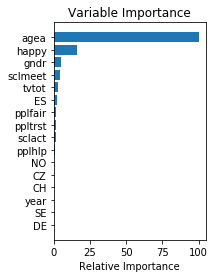

In [12]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

We first deal with ordinal features, use the category_encoders library to encode ordinal variables in this dataset

In [9]:
import category_encoders as ce
#encoder = ce.OrdinalEncoder(cols=['ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet', 'sclact'])
#df_new = encoder.fit_transform(df)

Since gender should not be numerical variable, we will transform them into categorical variable

In [15]:
df_new = df.copy()

In [16]:
# map the numeric value to categorical value
df_new = df_new.sample(len(df_new))
df_new['gndr'] = df_new['gndr'].map({2: 'F', 1:'M'})

Our last step is to transform the categorical variable into dummy variables

In [17]:
# transform categorical variables into dummy variables
df_new = pd.get_dummies(df_new.drop(['idno'], axis=1))

In [18]:
# we are ready give a first shot of fitting model
# split the train and test set
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_new.drop(['partner'], axis=1), df_new['partner'],
                                                   test_size=0.1, random_state=1009)
clf2 = ensemble.GradientBoostingClassifier(**params)
clf2.fit(X_train2, y_train2)
print(clf2.score(X_test2, y_test2))

0.7779141104294478


In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf2, df_new.drop(['partner'], axis=1), df_new['partner'], cv=10)

array([0.75245098, 0.74264706, 0.75367647, 0.73128834, 0.75798526,
       0.76289926, 0.77518428, 0.75429975, 0.74447174, 0.76535627])

Our first approach is only slightly better than the original, let's plot the feature importance plot to see which features have the most impact

In [20]:
X_train2.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,agea,cntry_CH,cntry_CZ,cntry_DE,cntry_ES,cntry_NO,cntry_SE,gndr_F,gndr_M
1704,6,2.0,0.0,3.0,1.0,7.0,5.0,2.0,54.0,0,1,0,0,0,0,0,1
2028,6,5.0,2.0,4.0,3.0,10.0,7.0,3.0,40.0,0,1,0,0,0,0,0,1
7756,7,3.0,6.0,7.0,7.0,8.0,7.0,4.0,76.0,0,0,0,0,0,1,1,0
6164,7,4.0,5.0,5.0,4.0,8.0,5.0,1.0,17.0,0,0,0,0,1,0,1,0
7131,6,2.0,5.0,8.0,5.0,9.0,4.0,3.0,57.0,0,0,0,0,0,1,1,0


In [21]:
feature = pd.DataFrame(clf2.feature_importances_, index=X_train2.columns,
                      columns=['importance']).sort_values('importance', ascending=False)
feature

,importance
agea,0.712112
happy,0.124777
sclmeet,0.037065
tvtot,0.023347
gndr_F,0.019758
cntry_ES,0.015070
pplfair,0.014572
gndr_M,0.014156
pplhlp,0.008570
sclact,0.008533


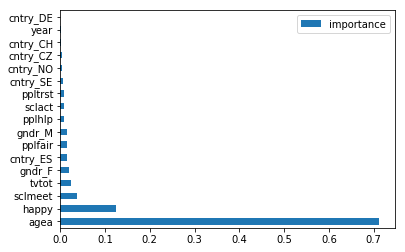

In [22]:
feature.plot(kind='barh')
plt.show()

In [23]:
# approach 2
# use the top6 features and tune the gradient boosting hyperparameters
important = feature.sort_values('importance', ascending=False)
from sklearn.model_selection import GridSearchCV
hyper_para = {
    'n_estimators': [500, 1000, 1500, 2000],
    'learning_rate': [0.1, 0.05, 0.5],
    'subsample':[0.5, 1],
    'loss': ['deviance', 'exponential'],
    'max_depth': [2,3,5]
}
clf3 = ensemble.GradientBoostingClassifier()
grid = GridSearchCV(clf3, param_grid=hyper_para, cv=5)

# use top 6 features to fit the model
grid.fit(X_train2[important.index[:6]], y_train2)
best_params = grid.best_params_
best_score = grid.best_score_

In [24]:
best_params

{'learning_rate': 0.05,
 'loss': 'deviance',
 'max_depth': 2,
 'n_estimators': 500,
 'subsample': 0.5}

In [45]:
# we will use the tuned parameter for cross validation test
clf_best = ensemble.GradientBoostingClassifier(**best_params)
cross_val_score(clf3, df_new[important.index[:6]], df_new['partner'], cv=10)

array([0.72671569, 0.75980392, 0.73284314, 0.7595092 , 0.75552826,
       0.75798526, 0.74078624, 0.75921376, 0.77149877, 0.73832924])